# Multivariate Limit Theorems via ACSV

This worksheet implements SageMath code for automatically computing central limit theorems from multivariate rational generating functions. Details on the theory behind the package can be found in Chapter 3 of the thesis or in the paper [*Central Limit Theorems via Analytic Combinatorics in Several Variables*](https://www.combinatorics.org/ojs/index.php/eljc/article/view/v31i2p27) by Stephen Melczer and Tiadora Ruza. 

Our code relies on the `sage_acsv` package available from the git repository [https://github.com/ACSVmath/sage_acsv](https://github.com/ACSVmath/sage_acsv). Our code for central limit theorems will be incorporated into future versions of the core `sage_acsv` package. The last stable version of `sage_acsv` can be installed from the command line on a computer with SageMath installed by running

`sage -pip install sage-acsv`

If the user has the [msolve](https://github.com/algebraic-solving/msolve) or [Macauly2](https://www.macaulay2.com) package installed on their machine (and visible to Sage), the back-end settings of `sage_acsv` can be modified to use either of these packages and speed up the calculations.

## Code for the Package - RUN THIS CELL FIRST

In [1]:
# Import the sage_acsv package for verifying minimal critical points
from sage_acsv import *

# Helper function
def HessianMatrixWithLog(H, vs, r):
    r"""Computes the Hessian matrix appearing in LCLT.

    INPUT:

    * ``H`` -- a polynomail (the denominator of the rational GF `F`)
    * ``vs`` -- list of variables ``z_1, ..., z_d``
    * ``r`` -- direction vector of length `d` with positive entries

    OUTPUT:

    The Hessian matrix with rational function entries in the variables of ``vs``.
    """
    z_d = vs[-1]
    d = len(vs)

    # Build d x d matrix of U[i,j] = z_i * z_j * H'_{z_i * z_j}
    U = matrix(
        [
            [
                v1 * v2 * H.derivative(v1, v2)/(z_d * H.derivative(z_d))
                for v2 in vs
            ] for v1 in vs
        ]
    )
    V = [(r[k] / r[-1]) for k in range(d)]

    # Build (d-1) x (d-1) Matrix for Hessian
    Hess = [
        [
            V[i] * V[j] + U[i][j] - V[j] * U[i][-1] - V[i]*U[j][-1]
            + V[i] * V[j] * U[-1][-1]
            for j in range(d-1)
        ] for i in range(d-1)
    ]
    for i in range(d-1):
        Hess[i][i] = Hess[i][i] + V[i]

    # Return Hessian
    return matrix(Hess)

# Main function to compute LCLT
def getLCLT(F, main_var, as_symbolic=False):
    r"""Take a multivariate rational generating function, check if it admits a 
    minimal critical point of a form implying a local central limit theorem, and
    (if so) return the local central limit theorem.

    INPUT:

    * ``F`` -- The rational function ``G/H`` in ``d`` variables. This function is
        assumed to have a combinatorial expansion.
    * ``main_var`` -- The variable that marks the ``size`` of the objects (so that the limit
        theorem holds as the exponent of ``main_var`` goes to infinity).
    * ``as_symbolic`` -- If ``True``, returns the limit theorem as an expression from the symbolic
        ring ``SR`` in the variable ``n``. If ``False``, the default, returns a tuple 
        (a, n^b, pi^b, C, D, v) such that the local central limit theorem is specified by the
        function f(s) = a^n * n^b * pi^b * C * exp(-((s-n*v)*D*(s-n*v).transpose())/2/n)

    OUTPUT:

    A representation of the local central limit theorem, either as a list of tuples,
    or as a symbolic expression.
    """

    # Initialize quantities
    G, H = F.numerator(), F.denominator()
    zvariables = [v for v in H.variables() if v != main_var]
    R = PolynomialRing(QQ,zvariables + [main_var])
    vs = R.gens()
    
    # Make sure G and H are coprime, and that H does not vanish at 0
    G, H = R(G), R(H)
    if H.subs({v: 0 for v in vs}) == 0:
        raise ValueError("Denominator vanishes at 0.")

    # Find rho
    P = H.subs({v: 1 for v in vs[0:-1]})
    rts = [r for r in QQ[vs[-1]](P).roots(AA, multiplicities=False) if r>0]
    if len(rts) == 0:
        raise ValueError("H(1,rho)=0 has no positive solution.")
    rho = min(rts)
    sbs = {v: 1 for v in vs[0:-1]} | {vs[-1]:rho}

    # Check numerator and denominator requirements are met
    if (H.derivative(vs[-1])).subs(sbs) == 0:
        raise ValueError("The partial derivative of the denominator at (1, rho) is 0.")
    
    if G.subs(sbs) == 0:
        raise ValueError("The numerator at (1, rho) is 0.")

    # Get direction for LCLT
    r = [H.derivative(v).subs(sbs)/(rho*H.derivative(vs[-1]).subs(sbs)) for v in vs[0:-1]] + [1]

    RR, (q, lambda_, u_) = PolynomialRing(QQ, 'q, lambda_, u_').objgens()
    expanded_R, _ = PolynomialRing(QQ, len(vs)+3, vs + (q, lambda_, u_)).objgens()

    vs = [expanded_R(v) for v in vs]
    q, lambda_, u_ = expanded_R(q), expanded_R(lambda_), expanded_R(u_)
    vsT = vs + [q, lambda_]
    G, H = expanded_R(G), expanded_R(H)

    all_variables = (vs, lambda_, q, u_)
    d = len(vs)
    rd = r[-1]

    for _ in range(ACSVSettings.MAX_MIN_CRIT_RETRIES):
        try:
            # Find minimal critical points in Kronecker Representation
            min_crit_pts = minimal_critical_points_combinatorial(
                G/H, #all_variables,
                r=r
            )

            if len(min_crit_pts) != 1 or min_crit_pts != [[1 for v in range(d-1)] + [rho]]:
                raise ValueError("The point (1,rho) is not the only critical point with this coordinate-wise modulus.")
            break
        except Exception as e:
            # In case form doesn't separate, we want to try again
            if isinstance(e, ACSVException) and e.retry:
                acsv_logger.warning(
                    "Randomly generated linear form was not suitable, "
                    f"encountered error: {e}\nRetrying..."
                )
                continue
            else:
                raise e
    
    sbs = {v:1 for v in vsT[0:-3]} | {vsT[-3]:rho}
    Hess = HessianMatrixWithLog(H, vsT[0:-2], r)
    Hess = Hess.subs({v:1 for v in Hess.base_ring().gens()[0:-4]} | {Hess.base_ring().gens()[-4]:rho})
    Det = Hess.determinant()

    if Det == 0:
        raise ValueError("Hessian determinant is 0.")

    # Values appearing in asymptotics
    base = 1/rho
    constant = - AA(G.subs(sbs) / rho / H.derivative(vs[-1]).subs(sbs) / (2^(d-1) * Det).sqrt())
    exponent = (1-d)/2

    s = matrix((var('s', n=d-1)))
    invHess = Hess.inverse()
    
    n = SR.var('n')
    result = (base, n^exponent, pi^exponent, constant, invHess, matrix(r[:-1]))
    
    if as_symbolic:
        (a, b, c, d, e, f) = result
        
        if a.degree() <= 2:
            a = base.radical_expression()
        if d.degree() <= 2:
            d = constant.radical_expression()
            
        if max([AA(k).degree() for k in e.list()] + [AA(k).degree() for k in r[:-1]]) <=2:
            sfactor = exp(-(((s-n*f)*e*(s-n*f).transpose())[0,0]).simplify()/2/n)
        else: 
            sfactor = exp(-(((s-n*f)*e*(s-n*f).transpose())[0,0])/2/n)
        
        result = a^n * b * c * d * sfactor

    return result

## Using the Package

The main function of the package is `getLCLT`

In [2]:
help(getLCLT)

Help on function getLCLT in module __main__:

getLCLT(F, main_var, as_symbolic=False)
    Take a multivariate rational generating function, check if it admits a 
    minimal critical point of a form implying a local central limit theorem, and
    (if so) return the local central limit theorem.
    
    INPUT:
    
    * ``F`` -- The rational function ``G/H`` in ``d`` variables. This function is
        assumed to have a combinatorial expansion.
    * ``main_var`` -- The variable that marks the ``size`` of the objects (so that the limit
        theorem holds as the exponent of ``main_var`` goes to infinity).
    * ``as_symbolic`` -- If ``True``, returns the limit theorem as an expression from the symbolic
        ring ``SR`` in the variable ``n``. If ``False``, the default, returns a tuple 
        (a, n^b, pi^b, C, D, v) such that the local central limit theorem is specified by the
        function f(s) = a^n * n^b * pi^b * C * exp(-((s-n*v)*D*(s-n*v).transpose())/2/n)
    
    OUTPUT:

To prove an LCLT, define the required symbolic variables then call the function with the rational generating function and the variable that determines the size of the underlying objects. Using the optional `as_symbolic = True` parameter returns everything in a one-line symbolic form.

In [3]:
# Limit theorem for number s0 of 0s in binary strings of length n
var('z t')
show(getLCLT(1/(1-z*t-t), t, as_symbolic = True))

sqrt(2)*2^n*e^(-1/2*(n - 2*s0)^2/n)/(sqrt(pi)*sqrt(n))

Not specifying the `as_symbolic` parameter \(or, equivalently, making it False\) returns a tuple $(a, n^b, \pi^b, C, D, \mathbf{v})$ such that the limit behaviour is specified by $f(\mathbf{s}) = a^n \, n^b \, \pi^b \, C \, \exp\left[-\frac{(\mathbf{s}-n\mathbf{v}) \; D \; (\mathbf{s}-n\mathbf{v})^T}{2n}\right]$


In [4]:
# Limit theorem for number s0 of 0s in binary strings of length n
var('z t')
LCLT1 = getLCLT(1/(1-z*t-t), t)
show(LCLT1)

(2, 1/sqrt(n), 1/sqrt(pi), 1.414213562373095?, [4], [1/2])

The quantities $a$ and $C$ are returned as algebraic numbers, while $D$ is a matrix with algebraic entries and $\mathbf{v}$ is a vector with algebraic entries. Algebraic numbers of degree at most 2 are automatically converted to radicals when `as_symbolic=True` but the quantities appearing are members of Sage's `Algebraic Real Field` in general. Returning a tuple allows easier access to the quantities in order to manipulate them as algebraic numbers.

In [5]:
C = LCLT1[3]
print(C)
print(parent(C))
print(C.minpoly())

1.414213562373095?
Algebraic Real Field
x^2 - 2


In [6]:
# Limit theorem for number s0 of 0s in 0123-strings of length n
var('z t')
show(getLCLT(1/(1-z*t-3*t), t, as_symbolic = True))

2*sqrt(2/3)*4^n*e^(-1/6*(n - 4*s0)^2/n)/(sqrt(pi)*sqrt(n))

`getLCLT` returns an error if one of the conditions that imply an LCLT are not satisfied

In [7]:
var('z t')
getLCLT(1/(1-z^2*t-t),t) # Periodicity due to even power of z

ValueError: The point (1,rho) is not the only critical point with this coordinate-wise modulus.

getLCLT will also give results, even if irrational directions are required. Note that this needs the newest version of sage_acsv to be installed.

In [8]:
# Permutation with restricted cycles
var('z t')
F = 1/(1-t-z*t^2)
show(getLCLT(F, t, as_symbolic = True))

1.710862642974252?*(1/2*sqrt(5) + 1/2)^n*e^(1/8*(n*(sqrt(5) - 1) - 2*sqrt(5)*s0)*(n*(sqrt(5) - 5) + 10*s0)/n)/(sqrt(pi)*sqrt(n))

The next example computes a limit theorem for the number of ways to maximally pack a path of length $m$ in a path of length $n$ and provides a limit theorem for number $s_0$ of copies of the smaller path. 

\(See Example 12.5 in Analytic Combinatorics in Several Variables 2nd Edition by Pemantle, Wilson, and Melczer for details on the generating function\)


In [9]:
var('x y')
m = 2
F = (1-x^m)/(1-x-x^m*(1-x^m)*y)
print("Limit theorem for m = ", m)
show(getLCLT(F, x, as_symbolic=True))

Limit theorem for m =  2


3.907129588084731?*1.324717957244746?^n*e^(-1/2*(-0.4114955886626458?*n + s0)*(-24.09277082519922?*n + 58.54928093761673?*s0)/n)/(sqrt(pi)*sqrt(n))

The following limit theorems apply to the sequence defined by the recurrence 

$f(a,b)= f(a−1,b−1)+ f(a−1,b−2)+2f(a−2,b−1)$ $(a,b\geq 2)$ 

with boundary conditions $f(a,b) = 0$ if $a < 0$ or $b < 0$ and $f(a,b) = 1$ when $0 \leq a \leq 1$ or $0 \leq b \leq 1$. We prove limit theorems for both parameters. 

In [10]:
var('x y')
F = 1/(1-x*y-x*y^2-2*x^2*y)
show(getLCLT(F, y, as_symbolic=True))
show(getLCLT(F, x, as_symbolic=True))

0.8869107284845746?*(1/2*sqrt(13) + 3/2)^n*e^(-1/200*(n*(7*sqrt(13) + 13) - 26*s0)*(n*(sqrt(13) + 7) - 2*sqrt(13)*s0)/n)/(sqrt(pi)*sqrt(n))

0.7665804598189022?*(sqrt(3) + 1)^n*e^(-1/22*(n*(2*sqrt(3) + 3) - 6*s0)*(n*(sqrt(3) + 2) - 2*sqrt(3)*s0)/n)/(sqrt(pi)*sqrt(n))

Our next example computes a limit theorem for the number of rows $s_0$ in horizontally convex polyominoes of size $n$. \(See Section 4.9 of Wilf's *generatingfunctionology* for a derivation of the generating function.\)

In [11]:
var('x y')
F = (x*y*(1-x)^3)/((1-x)^4-x*y*(1-x-x^2+x^3+x^2*y))
show(getLCLT(F, x, as_symbolic=True))

0.3450475264519037?*3.205569430400590?^n*e^(-1/2*(-0.4530745716375183?*n + s0)*(-3.296142343669530?*n + 7.275054814390697?*s0)/n)/(sqrt(pi)*sqrt(n))

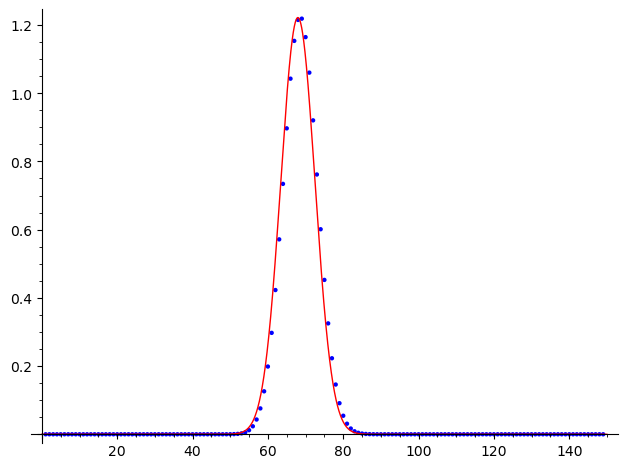

In [13]:
# Plot the computed limit theorem compared to coefficient extraction from GF when n=150
lc = getLCLT(F, x, as_symbolic=True)
TMP.<X,Y> = QQ[['X,Y']]
P = (X*Y*(1-X)^3)/((1-X)^4-X*Y*(1-X-X^2+X^3+X^2*Y) + O(X^302))
cfs = P.coefficients()
lst = [[k,cfs[X^150*Y^k]] for k in range(1,150)]
p1 = points(lst)
p2=plot(lc.subs(n=150),s0,0,150, color='red')
show(p1 + p2)

## Further Examples from Melczer Ruza Paper



#### Strings with Tracked Letters

In [14]:
# Limit theorem for number s0 of 0s in binary strings of length n
var('z t')
show(getLCLT(1/(1-z*t-t), t, as_symbolic = True))

sqrt(2)*2^n*e^(-1/2*(n - 2*s0)^2/n)/(sqrt(pi)*sqrt(n))

In [15]:
# Limit theorem for number s0 of 0s in 0123-strings of length n
var('z t')
show(getLCLT(1/(1-z*t-3*t), t, as_symbolic = True))

2*sqrt(2/3)*4^n*e^(-1/6*(n - 4*s0)^2/n)/(sqrt(pi)*sqrt(n))

In [16]:
# Limit theorem for number s0 of 0s and s1 of 1s in 012-strings of length n
var('x y t')
F = 1/(1-x*t-y*t-t)
show(getLCLT(F, t, as_symbolic = True))

3/2*sqrt(3)*3^n*e^(-1/2*((n - 2*s0 - s1)*(n - 3*s0) + (n - s0 - 2*s1)*(n - 3*s1))/n)/(pi*n)

In [17]:
# Limit theorem for number s0 of 0s and s1 of 1s in 01234-strings of length n
var('x y t')
F = 1/(1-x*t-y*t-3*t)
show(getLCLT(F, t, as_symbolic = True))

5/2*sqrt(5/3)*5^n*e^(-1/6*((n - 4*s0 - s1)*(n - 5*s0) + (n - s0 - 4*s1)*(n - 5*s1))/n)/(pi*n)

#### Compositions with Tracked Summands

In [18]:
# Limit theorem for number s0 of the 1s in compositions of length n
var('x t')
F = 1/(1-x*t-t^2/(1-t))
show(getLCLT(F, t, as_symbolic = True))

sqrt(2/5)*2^n*e^(-1/10*(n - 4*s0)^2/n)/(sqrt(pi)*sqrt(n))

In [19]:
# Limit theorem for number s0 of 1s and s1 of 2s in compositions of length n
var('x y t')
F = 1/(1-x*t-y*t^2-t^3/(1-t))
show(getLCLT(F, t, as_symbolic = True))

8*sqrt(1/35)*2^n*e^(-1/70*(7*(n - 4*s0)^2 + 5*(n - 8*s1)^2)/n)/(pi*n)

In [20]:
# Limit theorem for number s0 of 1s, s1 of 2s and s2 of 3s in compositions of length n
var('z1 z2 z3 t')
F = 1/(1-z1*t-z2*t^2-z3*t^3-t^4/(1-t))
show(getLCLT(F, t, as_symbolic = True))

32*sqrt(2/107)*2^n*e^(-1/214*((24*n - 87*s0 - 4*s1 - 28*s2)*(n - 4*s0) + (19*n - 2*s0 - 128*s1 - 40*s2)*(n - 8*s1) + (13*n - 7*s0 - 20*s1 - 140*s2)*(n - 16*s2))/n)/(pi^(3/2)*n^(3/2))

#### Permutations with Restricted Cycles

In [21]:
# If a newer branch of sage_acsv that supports irrational directions is installed, we can prove the result
# by specifying the parameter support_irrat = True
var('z t')
F = 1/(1-t-z*t^2)
show(getLCLT(F, t, as_symbolic = True))

1.710862642974252?*(1/2*sqrt(5) + 1/2)^n*e^(1/8*(n*(sqrt(5) - 1) - 2*sqrt(5)*s0)*(n*(sqrt(5) - 5) + 10*s0)/n)/(sqrt(pi)*sqrt(n))

In [22]:
var('x y t')
F = 1/(1-t-x*t^2-y*t^3)
show(getLCLT(F, t, as_symbolic=True))

5.030774639167280?*1.839286755214161?^n*e^(-1/2*((-0.1828035329682955?*n + s0)*(-4.331318273807052?*n + 15.75001457299826?*s0 + 14.61097905351492?*s1) + (-0.0993882723561560?*n + s1)*(-5.688465294663696?*n + 14.61097905351492?*s0 + 30.36099362651318?*s1))/n)/(pi*n)